# Predict Job failures in advance for system jobs

## Data 
https://www.kaggle.com/datasets/skylarkphantom/mit-datacenter-challenge-data


**About Dataset**
TDatacenter monitoring systems offer a variety of data streams and events. The Datacenter Challenge datasets are a combination of high-level data (e.g. Slurm Workload Manager scheduler data) and low-level job-specific time series data. The high-level data includes parameters such as the number of nodes requested, number of CPU/GPU/memory requests, exit codes, and run time data. The low-level time series data is collected on the order of seconds for each job. This granular time series data includes CPU/GPU/memory utilization, amount of disk I/O, and environmental parameters such as power drawn and temperature. Ideally, leveraging both high-level scheduler data and low-level time series data will facilitate the development of AI/ML algorithms which not only predict/detect failures, but also allow for the accurate determination of their cause.

## Citation:
S. Samsi et al., "The MIT Supercloud Dataset," 2021 IEEE High Performance Extreme Computing Conference (HPEC), Waltham, MA, USA, 2021, pp. 1-8, doi: 10.1109/HPEC49654.2021.9622850.
Samsi, Siddharth, Weiss, Matthew, Bestor, David, et al. "The MIT Supercloud Dataset." 2021 IEEE High Performance Extreme Computing Conference (HPEC). IEEE, 2021.


**Install xgboost to include in the list of classifiers. comment the pip install command so it doesn't run every time**

In [3]:
#pip install xgboost

# Import Libraries

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["figure.figsize"] = (15,9)
plt.style.use("fivethirtyeight")
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.feature_selection import SelectFromModel
import time
#from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn import set_config, tree
from xgboost import XGBClassifier, plot_importance

set_config(display="diagram")
import warnings
warnings.filterwarnings("ignore")

# Load Data

## Load High Level Data Set Scheduler

Data file: data/scheduler_data.csv

shape: 287173, 31

In [5]:
hl_df = pd.read_csv('data/scheduler_data.csv') # High level data

In [6]:
hl_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287173 entries, 0 to 287172
Data columns (total 31 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id_array_job        287173 non-null  int64  
 1   id_array_task       287173 non-null  int64  
 2   id_user             287173 non-null  int64  
 3   kill_requid         287173 non-null  int64  
 4   nodes_alloc         287173 non-null  int64  
 5   nodelist            287173 non-null  object 
 6   cpus_req            287173 non-null  int64  
 7   derived_ec          287173 non-null  int64  
 8   exit_code           287173 non-null  int64  
 9   gres_req            216676 non-null  object 
 10  gres_alloc          216676 non-null  object 
 11  gres_used           0 non-null       float64
 12  array_max_tasks     287173 non-null  int64  
 13  array_task_pending  287173 non-null  int64  
 14  constraints         287173 non-null  object 
 15  flags               287173 non-nul

In [7]:
hl_df.head()

,id_array_job,id_array_task,id_user,kill_requid,nodes_alloc,nodelist,cpus_req,derived_ec,exit_code,gres_req,...,time_submit,time_eligible,time_start,time_end,time_suspended,track_steps,tres_alloc,tres_req,job_type,id_job
0,41161693674,4595979483,66088413977,51671871839,0,[],1,0,256,NaN,...,3014,3014,3014,3014,-1,0,NaN,"1=1,2=5000,4=1,5=1,1002=2",OTHER,13715936505
1,41161693674,4595979483,66088413977,51671871839,1,['r2684277-n303509'],1,0,0,gpu:volta:2,...,3022,3022,3022,3025,-1,0,"1=1,2=9600,4=1,5=1,1002=2","1=1,2=9600,4=1,5=1,1002=2",OTHER,25780056187
2,41161693674,4595979483,16176946191,51671871839,1,['r5198790-n347934'],4,32512,32512,gpu:volta:1,...,5682,5682,5683,5684,-1,0,"1=4,2=38400,4=1,5=4,1002=1","1=4,2=38400,4=1,5=4,1002=1",OTHER,53722449986
3,41161693674,4595979483,16176946191,16176946191,1,['r3541344-n655125'],4,0,0,gpu:volta:1,...,34467,34467,34468,34548,-1,0,"1=4,2=20000,4=1,5=4,1002=1","1=4,2=20000,4=1,5=4,1002=1",OTHER,19989272070
4,41161693674,4595979483,16176946191,16176946191,1,['r3541344-n655125'],4,0,0,gpu:volta:1,...,34596,34596,34596,35108,-1,0,"1=4,2=20000,4=1,5=4,1002=1","1=4,2=20000,4=1,5=4,1002=1",OTHER,49220239266


## Load Low level Data set DCGM

Data File: data/dcgm.csv

Shape: (96893, 23)

In [8]:
ll_df = pd.read_csv('data/dcgm.csv') # Low level data
ll_df.info()
ll_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96893 entries, 0 to 96892
Data columns (total 23 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Node                           96893 non-null  object 
 1   avgmemoryutilization_pct       96893 non-null  float64
 2   avgsmutilization_pct           96893 non-null  float64
 3   energyconsumed_joules          96893 non-null  float64
 4   gpu_id                         96893 non-null  int64  
 5   maxgpumemoryused_bytes         96893 non-null  float64
 6   memoryutilization_pct_avg      96893 non-null  float64
 7   memoryutilization_pct_max      96893 non-null  float64
 8   memoryutilization_pct_min      96893 non-null  float64
 9   pcierxbandwidth_megabytes_avg  96893 non-null  float64
 10  pcierxbandwidth_megabytes_max  96893 non-null  float64
 11  pcierxbandwidth_megabytes_min  96893 non-null  float64
 12  pcietxbandwidth_megabytes_avg  96893 non-null 

,Node,avgmemoryutilization_pct,avgsmutilization_pct,energyconsumed_joules,gpu_id,maxgpumemoryused_bytes,memoryutilization_pct_avg,memoryutilization_pct_max,memoryutilization_pct_min,pcierxbandwidth_megabytes_avg,...,pcietxbandwidth_megabytes_max,pcietxbandwidth_megabytes_min,powerusage_watts_avg,powerusage_watts_max,powerusage_watts_min,smutilization_pct_avg,smutilization_pct_max,smutilization_pct_min,totalexecutiontime_sec,id_job
0,r9170217-n750018,0.0,1.0,157521.0,0,2.645557e+09,3.0,24.0,0.0,1646.0,...,1530.0,676.0,44.0546,156.962,25.468,11.0,64.0,0.0,4452.47,4393785332
1,r44132-n469339,0.0,0.0,0.0,1,0.000000e+00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0000,0.000,0.000,0.0,0.0,0.0,0.54,18177101425
2,r5354770-n172107,0.0,3.0,94816.0,0,2.917171e+07,0.0,0.0,0.0,1846.0,...,1872.0,1346.0,26.3725,27.483,25.979,6.0,43.0,0.0,8398.30,39529488078
3,r1900814-n772143,0.0,0.0,69451.0,0,1.527587e+09,0.0,1.0,0.0,539.0,...,337.0,293.0,37.5481,52.039,26.676,1.0,25.0,0.0,1851.72,19994333952
4,r9515777-n469339,0.0,0.0,0.0,1,0.000000e+00,0.0,0.0,0.0,1991.0,...,1109.0,1109.0,25.0320,25.032,25.032,0.0,0.0,0.0,0.99,397881706


# Exploratory Data Analysis (EDA)

## Data Exploration (High level Schedular data)

null values: will be handled after the manual feature selection is performed
Duplicates: No duplicates

In [10]:
hl_df.isna().mean()

id_array_job          0.000000
id_array_task         0.000000
id_user               0.000000
kill_requid           0.000000
nodes_alloc           0.000000
nodelist              0.000000
cpus_req              0.000000
derived_ec            0.000000
exit_code             0.000000
gres_req              0.245486
gres_alloc            0.245486
gres_used             1.000000
array_max_tasks       0.000000
array_task_pending    0.000000
constraints           0.000000
flags                 0.000000
mem_req               0.000000
partition             0.000000
priority              0.000000
state                 0.000000
timelimit             0.000000
time_submit           0.000000
time_eligible         0.000000
time_start            0.000000
time_end              0.000000
time_suspended        0.000000
track_steps           0.000000
tres_alloc            0.245577
tres_req              0.000000
job_type              0.000000
id_job                0.000000
dtype: float64

In [11]:
hl_df.duplicated().sum()

0

### Bi-Variate Analysis

Any feature having near 1 correlation will provide the same results for prediction, hence only one needs to kept in the table

Hint: Keep the one with highest correlation with target column "exit_code'

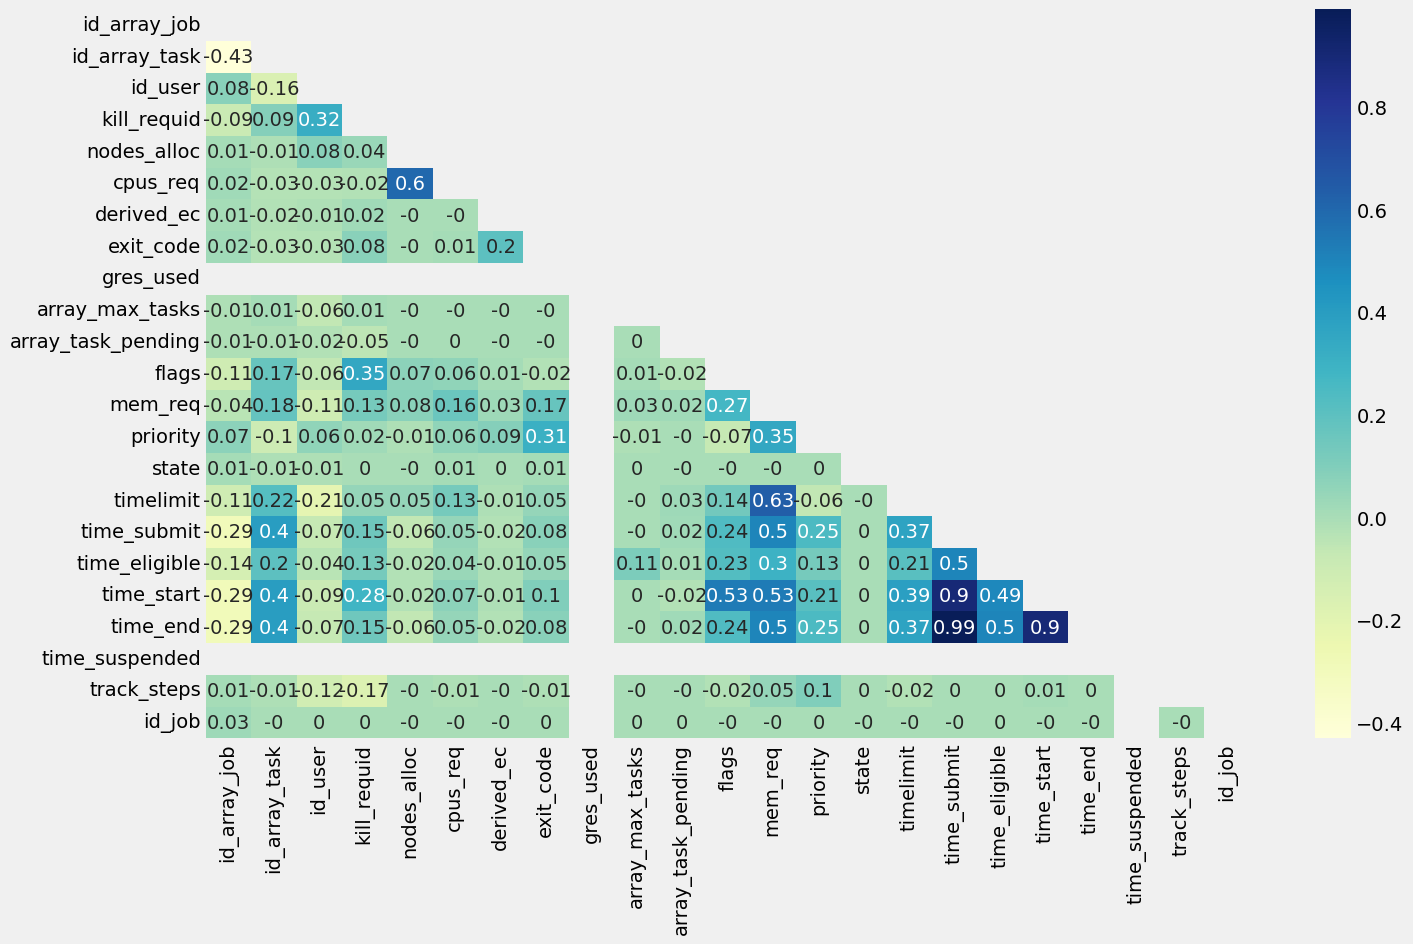

In [13]:
mask = np.triu(np.ones_like(hl_df.corr().round(2)))
sns.heatmap(hl_df.corr().round(2), annot=True, mask=mask, cmap="YlGnBu");

In [14]:
# Explore the highly correlated time_start, time_end and time_submit
hl_df[['time_start', 'time_end', 'time_submit']]

,time_start,time_end,time_submit
0,3014,3014,3014
1,3022,3025,3022
2,5683,5684,5682
3,34468,34548,34467
4,34596,35108,34596
...,...,...,...
287168,32000935,32000955,32000935
287169,32001024,32001040,32001024
287170,32001104,-1,32001104
287171,32001410,-1,32001410


#### drop column time_submit and time_end, highly correlated with time_start

In [15]:
# drop column time_submit and time_end, since time_start shows high correlation with target column exit_code
hl_col_to_drop = ['time_submit','time_end' ]

print(hl_col_to_drop)

['time_submit', 'time_end']


#### Inspect and drop empty features

In [16]:
# inspect time_suspended as the row seems empty in heatmap
hl_df.time_suspended.unique()

array([-1])

In [17]:
#drop the above column 
hl_col_to_drop.append('time_suspended')
print(hl_col_to_drop)

['time_submit', 'time_end', 'time_suspended']


In [18]:
hl_df.drop(hl_col_to_drop, inplace=True, axis=1)

### UniVariate Analysis

In [19]:
hl_df.describe(include='O')

,nodelist,gres_req,gres_alloc,constraints,partition,tres_alloc,tres_req,job_type
count,287173,216676,216676,287173,287173,216650,287173,287173
unique,2187,51,42,4,5,595,622,4
top,[],gpu:volta:1,gpu:1,xeon-g6,gpu,"1=1,2=10240,4=1,5=1,1001=1","1=1,2=10240,4=1,5=1,1001=1",OTHER
freq,70525,95687,185261,283084,141342,75430,129274,238887


#### drop the columns that has all NaNs

In [20]:
hl_df.gres_used.unique()

array([nan])

In [21]:
# drop the columns that has all NaNs
hl_col_to_drop = ['gres_used']

In [22]:
hl_df.exit_code.unique()

array([  256,     0, 32512,   768, 59648,   512, 33280, 35072,  8960,
        2304, 35584,   253, 32256, 34304, 65280, 32768,  2048,  4608,
        3328,     9, 33024, 15104, 34816,  1024,  1792, 34560, 37888,
       30720, 65024, 33792,  5120, 31744, 59392, 61952, 33536,    15])

In [23]:
hl_df.state.unique()

array([   5,    3,    4,    6,    7,   11, 1024,    1,    0])

In [24]:
hl_df.gres_req.unique()

array([nan, 'gpu:volta:2', 'gpu:volta:1', 'gpu:volta:870',
       'gpu:volta:800', 'gpu:volta:4', 'gpu:volta:16', 'gpu:volta:8',
       'gpu:volta:64', 'gpu:volta:32', 'gpu:volta:128', 'gpu:volta:256',
       'gpu:volta:768', 'gpu:volta:512', 'gpu:volta:6', 'gpu:volta:856',
       'gpu:volta:864', 'gpu:volta:832', 'gpu:volta:680', 'gpu:volta:640',
       'gpu:volta:600', 'gpu:volta:560', 'gpu:volta:540', 'gpu:volta:520',
       'gpu:volta:830', 'gpu:volta:850', 'gpu:volta:48', 'gpu:volta:12',
       'gpu:volta:24', 'gpu:volta:20', 'gpu:volta:28', 'gpu:2', 'gpu:1',
       'gpu:volta:150', 'gpu:volta:786', 'gpu:volta:700', 'gpu:volta:58',
       'gpu:volta:5', 'gpu:volta:696', 'gpu:volta:3', 'gpu:volta:192',
       'gpu:volta:130', 'gpu:4', 'gpu:volta:252', 'gpu:32',
       'gpu:volta:10', 'gpu:16', 'gpu:8', 'gpu:volta:14', 'gpu:3',
       'gpu:12', 'gpu:64'], dtype=object)

In [25]:
hl_df['flags'].unique()

array([ 0,  2,  4,  8, 12])

In [26]:
hl_df.tres_alloc.unique()

array([nan, '1=1,2=9600,4=1,5=1,1002=2', '1=4,2=38400,4=1,5=4,1002=1',
       '1=4,2=20000,4=1,5=4,1002=1', '1=40,2=384000,4=1,5=40,1002=2',
       '1=4,2=38400,4=1,5=4,1002=2', '1=2,2=19200,4=1,5=2,1002=2',
       '1=2,2=19200,3=18446744073709551614,4=1,5=2,1002=2',
       '1=870,2=8352000,4=435,5=870,1002=870',
       '1=800,2=7680000,4=400,5=800,1002=800',
       '1=4,2=38400,4=2,5=4,1002=4', '1=16,2=153600,4=8,5=16,1002=16',
       '1=8,2=76800,4=4,5=8,1002=8', '1=64,2=614400,4=32,5=64,1002=64',
       '1=32,2=307200,4=16,5=32,1002=32',
       '1=128,2=1228800,4=64,5=128,1002=128',
       '1=256,2=2457600,4=128,5=256,1002=256',
       '1=768,2=7372800,4=384,5=768,1002=768',
       '1=512,2=4915200,4=256,5=512,1002=512',
       '1=1,2=5000,4=1,5=1,1002=1', '1=8,2=40000,4=1,5=8,1002=1',
       '1=1,2=5000,3=18446744073709551614,4=1,5=1,1002=2',
       '1=12,2=60000,4=1,5=12,1002=1', '1=2,2=19200,4=2,5=2,1002=2',
       '1=28,2=140000,4=1,5=28,1002=1', '1=28,2=140000,4=1,5=28,1002=2',

In [27]:
hl_df.job_type.unique()

array(['OTHER', 'LLSUB:INTERACTIVE', 'LLSUB:BATCH', 'LLMAPREDUCE:MAP'],
      dtype=object)

#### Drop the columns with complicated values and high unique numbers

In [28]:
#Drop the columns with complicated values and high unique numbers
#Note: Keeping the nodelist until the 2 dataframes are merged
hl_col_to_drop.append('tres_alloc')
hl_col_to_drop.append('tres_req')
print(hl_col_to_drop)

['gres_used', 'tres_alloc', 'tres_req']


In [29]:
hl_df.drop(hl_col_to_drop, inplace=True, axis=1)
print(hl_df.info())
hl_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287173 entries, 0 to 287172
Data columns (total 25 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   id_array_job        287173 non-null  int64 
 1   id_array_task       287173 non-null  int64 
 2   id_user             287173 non-null  int64 
 3   kill_requid         287173 non-null  int64 
 4   nodes_alloc         287173 non-null  int64 
 5   nodelist            287173 non-null  object
 6   cpus_req            287173 non-null  int64 
 7   derived_ec          287173 non-null  int64 
 8   exit_code           287173 non-null  int64 
 9   gres_req            216676 non-null  object
 10  gres_alloc          216676 non-null  object
 11  array_max_tasks     287173 non-null  int64 
 12  array_task_pending  287173 non-null  int64 
 13  constraints         287173 non-null  object
 14  flags               287173 non-null  int64 
 15  mem_req             287173 non-null  uint64
 16  pa

,id_array_job,id_array_task,id_user,kill_requid,nodes_alloc,nodelist,cpus_req,derived_ec,exit_code,gres_req,...,mem_req,partition,priority,state,timelimit,time_eligible,time_start,track_steps,job_type,id_job
0,41161693674,4595979483,66088413977,51671871839,0,[],1,0,256,NaN,...,9223372036854780808,gpu,19995,5,720,3014,3014,0,OTHER,13715936505
1,41161693674,4595979483,66088413977,51671871839,1,['r2684277-n303509'],1,0,0,gpu:volta:2,...,9223372036854785408,gaia,19995,3,4294967295,3022,3022,0,OTHER,25780056187
2,41161693674,4595979483,16176946191,51671871839,1,['r5198790-n347934'],4,32512,32512,gpu:volta:1,...,9223372036854785408,gaia,110012,5,4294967295,5682,5683,0,OTHER,53722449986
3,41161693674,4595979483,16176946191,16176946191,1,['r3541344-n655125'],4,0,0,gpu:volta:1,...,9223372036854780808,gpu,110023,4,720,34467,34468,0,OTHER,19989272070
4,41161693674,4595979483,16176946191,16176946191,1,['r3541344-n655125'],4,0,0,gpu:volta:1,...,9223372036854780808,gpu,110006,4,720,34596,34596,0,OTHER,49220239266


## Data Exploration (low level DGCM Data)

The data frame doesn't contain the target column, so the bi-variate analysis should be conducted on merged data frame.

simply indetify the Nans and duplicate data: no null, no duplicate

In [32]:
ll_df.isna().mean()

Node                             0.0
avgmemoryutilization_pct         0.0
avgsmutilization_pct             0.0
energyconsumed_joules            0.0
gpu_id                           0.0
maxgpumemoryused_bytes           0.0
memoryutilization_pct_avg        0.0
memoryutilization_pct_max        0.0
memoryutilization_pct_min        0.0
pcierxbandwidth_megabytes_avg    0.0
pcierxbandwidth_megabytes_max    0.0
pcierxbandwidth_megabytes_min    0.0
pcietxbandwidth_megabytes_avg    0.0
pcietxbandwidth_megabytes_max    0.0
pcietxbandwidth_megabytes_min    0.0
powerusage_watts_avg             0.0
powerusage_watts_max             0.0
powerusage_watts_min             0.0
smutilization_pct_avg            0.0
smutilization_pct_max            0.0
smutilization_pct_min            0.0
totalexecutiontime_sec           0.0
id_job                           0.0
dtype: float64

In [33]:
sum(ll_df.duplicated())

0

**Note: do not drop any features on DGCM(Low level) dataframe until merged in order to explore it against the target values**

# Merge High level(Schedular) and Low level(DCGM) DataFrames

**Note: id_job is the common field in both the databases, hence will be used for joining the DataFrames**


## Explore id_job column in both DFs

In [34]:
print(hl_df.shape)
hl_df.id_job.nunique()


(287173, 25)


287069

### find and drop the duplicates
**Process Logic: 1) find "all" the Duplicates of the columns id_job.  2) keep only the Failed job, as that is more importatnt for our problem statement**

In [35]:
#find the duplicates
hl_dup_ids = hl_df.loc[hl_df['id_job'].duplicated(keep=False)][['id_job', 'state']]
print(hl_dup_ids.shape) 

#Each job has multiple rows, some with failed state, and final success state.
# Keep only the failed jobs out of all states of a particular job_id
print(len(hl_dup_ids.index[hl_dup_ids['state'] != 3].tolist()))
hl_df = hl_df.drop(hl_dup_ids.index[hl_dup_ids['state'] != 3].tolist())
print(hl_df.shape)
print(hl_df.id_job.nunique())

(194, 2)
163
(287010, 25)
287010


## Set Index to id_job for High level data set

In [36]:
## Set the index to id_job for merging
hl_df.set_index('id_job')

,id_array_job,id_array_task,id_user,kill_requid,nodes_alloc,nodelist,cpus_req,derived_ec,exit_code,gres_req,...,flags,mem_req,partition,priority,state,timelimit,time_eligible,time_start,track_steps,job_type
id_job,,,,,,,,,,,,,,,,,,,,,
13715936505,41161693674,4595979483,66088413977,51671871839,0,[],1,0,256,NaN,...,0,9223372036854780808,gpu,19995,5,720,3014,3014,0,OTHER
25780056187,41161693674,4595979483,66088413977,51671871839,1,['r2684277-n303509'],1,0,0,gpu:volta:2,...,2,9223372036854785408,gaia,19995,3,4294967295,3022,3022,0,OTHER
53722449986,41161693674,4595979483,16176946191,51671871839,1,['r5198790-n347934'],4,32512,32512,gpu:volta:1,...,4,9223372036854785408,gaia,110012,5,4294967295,5682,5683,0,OTHER
19989272070,41161693674,4595979483,16176946191,16176946191,1,['r3541344-n655125'],4,0,0,gpu:volta:1,...,4,9223372036854780808,gpu,110023,4,720,34467,34468,0,OTHER
49220239266,41161693674,4595979483,16176946191,16176946191,1,['r3541344-n655125'],4,0,0,gpu:volta:1,...,4,9223372036854780808,gpu,110006,4,720,34596,34596,0,OTHER
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12345742021,41161693674,4595979483,25399748967,51671871839,1,['r810901-n172107'],40,0,256,gpu:volta:1,...,4,9223372036854784308,normal,110454,5,4294967295,32000935,32000935,0,OTHER
47595151481,41161693674,4595979483,35441973637,51671871839,1,['r810901-n172107'],1,0,33280,gpu:volta:1,...,2,9223372036854784308,normal,110061,5,1440,32001024,32001024,0,LLSUB:INTERACTIVE
41166593563,41161693674,4595979483,38723761107,51671871839,1,['r810901-n172107'],1,0,0,gpu:volta:1,...,2,9223372036854784308,normal,110600,1,1440,32001104,32001104,0,OTHER


## Set Index to id_job for Low Level Data set

In [37]:
## Set Index to ID_job for low level DGCM Dataframe
ll_df.set_index('id_job')

,Node,avgmemoryutilization_pct,avgsmutilization_pct,energyconsumed_joules,gpu_id,maxgpumemoryused_bytes,memoryutilization_pct_avg,memoryutilization_pct_max,memoryutilization_pct_min,pcierxbandwidth_megabytes_avg,...,pcietxbandwidth_megabytes_avg,pcietxbandwidth_megabytes_max,pcietxbandwidth_megabytes_min,powerusage_watts_avg,powerusage_watts_max,powerusage_watts_min,smutilization_pct_avg,smutilization_pct_max,smutilization_pct_min,totalexecutiontime_sec
id_job,,,,,,,,,,,,,,,,,,,,,
4393785332,r9170217-n750018,0.0,1.0,157521.0,0,2.645557e+09,3.0,24.0,0.0,1646.0,...,971.0,1530.0,676.0,44.0546,156.962,25.468,11.0,64.0,0.0,4452.47
18177101425,r44132-n469339,0.0,0.0,0.0,1,0.000000e+00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0000,0.000,0.000,0.0,0.0,0.0,0.54
39529488078,r5354770-n172107,0.0,3.0,94816.0,0,2.917171e+07,0.0,0.0,0.0,1846.0,...,1785.0,1872.0,1346.0,26.3725,27.483,25.979,6.0,43.0,0.0,8398.30
19994333952,r1900814-n772143,0.0,0.0,69451.0,0,1.527587e+09,0.0,1.0,0.0,539.0,...,314.0,337.0,293.0,37.5481,52.039,26.676,1.0,25.0,0.0,1851.72
397881706,r9515777-n469339,0.0,0.0,0.0,1,0.000000e+00,0.0,0.0,0.0,1991.0,...,1109.0,1109.0,1109.0,25.0320,25.032,25.032,0.0,0.0,0.0,0.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19023940853,r8141575-n469339,0.0,0.0,1007.0,0,0.000000e+00,0.0,0.0,0.0,228.0,...,145.0,145.0,145.0,25.7800,25.886,25.693,0.0,0.0,0.0,39.94
64323977349,r974863-n303766,0.0,0.0,28046.0,0,1.173357e+09,0.0,0.0,0.0,1809.0,...,1589.0,1589.0,1588.0,26.1930,36.655,25.664,0.0,9.0,0.0,1072.84
4512455793,r2215649-n410412,27.0,98.0,644399.0,1,3.129265e+10,27.0,37.0,0.0,1937.0,...,942.0,953.0,931.0,179.2710,211.224,53.471,99.0,100.0,0.0,25054.80


## Merge DFs

In [38]:
## Merge both DFs

merged_df = pd.merge(left=ll_df, right=hl_df, on='id_job', how='inner')
print(merged_df.shape)

(96805, 47)


In [39]:
merged_df.head()

,Node,avgmemoryutilization_pct,avgsmutilization_pct,energyconsumed_joules,gpu_id,maxgpumemoryused_bytes,memoryutilization_pct_avg,memoryutilization_pct_max,memoryutilization_pct_min,pcierxbandwidth_megabytes_avg,...,flags,mem_req,partition,priority,state,timelimit,time_eligible,time_start,track_steps,job_type
0,r9170217-n750018,0.0,1.0,157521.0,0,2.645557e+09,3.0,24.0,0.0,1646.0,...,4,9223372036854784308,normal,10509,4,4294967295,26341708,26341708,0,LLSUB:BATCH
1,r44132-n469339,0.0,0.0,0.0,1,0.000000e+00,0.0,0.0,0.0,0.0,...,4,9223372036854784308,normal,10912,3,4294967295,23378740,23378740,0,OTHER
2,r5354770-n172107,0.0,3.0,94816.0,0,2.917171e+07,0.0,0.0,0.0,1846.0,...,2,9223372036854784308,normal,110935,5,4294967295,23094718,23094718,0,LLSUB:INTERACTIVE
3,r1900814-n772143,0.0,0.0,69451.0,0,1.527587e+09,0.0,1.0,0.0,539.0,...,4,9223372036854784308,normal,10520,4,4294967295,24845442,24845442,0,LLSUB:BATCH
4,r9515777-n469339,0.0,0.0,0.0,1,0.000000e+00,0.0,0.0,0.0,1991.0,...,4,9223372036854784308,normal,10912,5,4294967295,23377440,23377440,0,OTHER


# Data Exploration and Cleanup on merged_df

In [40]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96805 entries, 0 to 96804
Data columns (total 47 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Node                           96805 non-null  object 
 1   avgmemoryutilization_pct       96805 non-null  float64
 2   avgsmutilization_pct           96805 non-null  float64
 3   energyconsumed_joules          96805 non-null  float64
 4   gpu_id                         96805 non-null  int64  
 5   maxgpumemoryused_bytes         96805 non-null  float64
 6   memoryutilization_pct_avg      96805 non-null  float64
 7   memoryutilization_pct_max      96805 non-null  float64
 8   memoryutilization_pct_min      96805 non-null  float64
 9   pcierxbandwidth_megabytes_avg  96805 non-null  float64
 10  pcierxbandwidth_megabytes_max  96805 non-null  float64
 11  pcierxbandwidth_megabytes_min  96805 non-null  float64
 12  pcietxbandwidth_megabytes_avg  96805 non-null 

In [41]:
merged_df.describe(include='O')

,Node,nodelist,gres_req,gres_alloc,constraints,partition,job_type
count,96805,96805,96805,96805,96805,96805,96805
unique,225,662,21,12,3,3,4
top,r3955005-n172107,['r3955005-n172107'],gpu:volta:1,gpu:1,xeon-g6,normal,OTHER
freq,1151,1147,61177,65010,96179,92211,65076


## Drop columns with high number of Unique values

In [42]:
# Drop columns with high number of unique values, 
## but leaving gres_req as this is importatnt feature to explore in detail
merged_df.drop(['Node', 'nodelist', 'id_array_job'], axis=1, inplace=True, errors='ignore')

## BiVariate Analysis

### correlation heatmap for all columns

<AxesSubplot:>

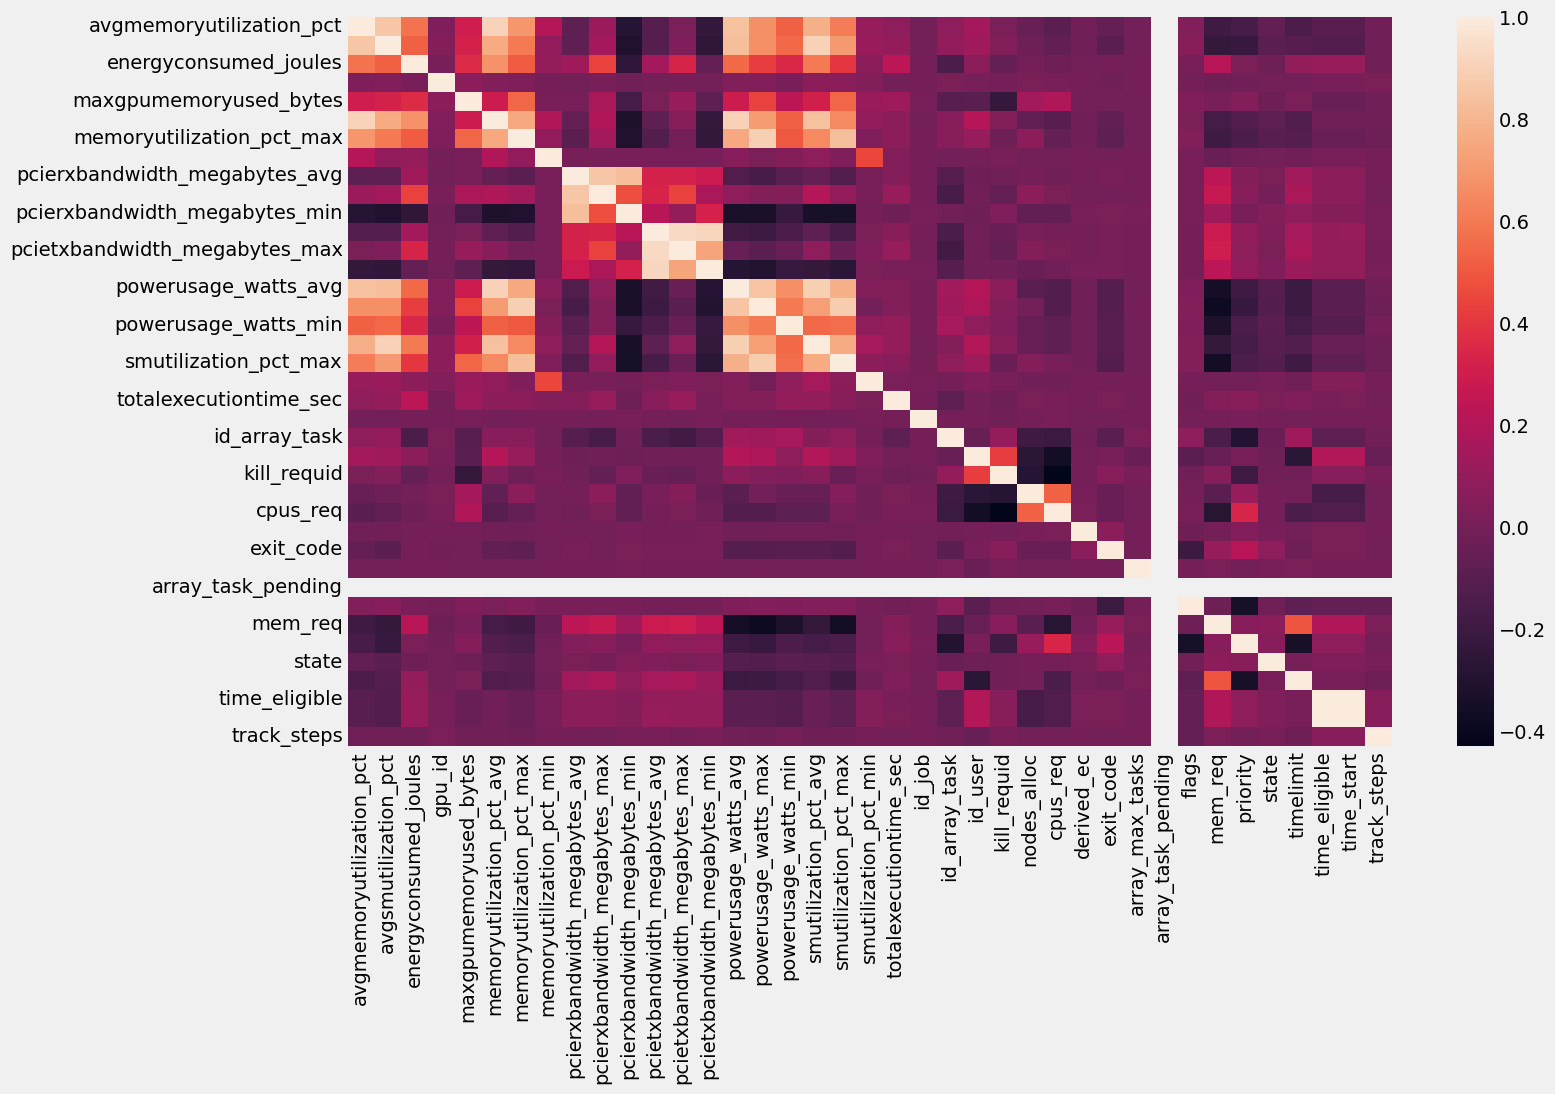

In [43]:
sns.heatmap(merged_df.corr().round(2))

### Get Correaltion with taget 'exit_code'

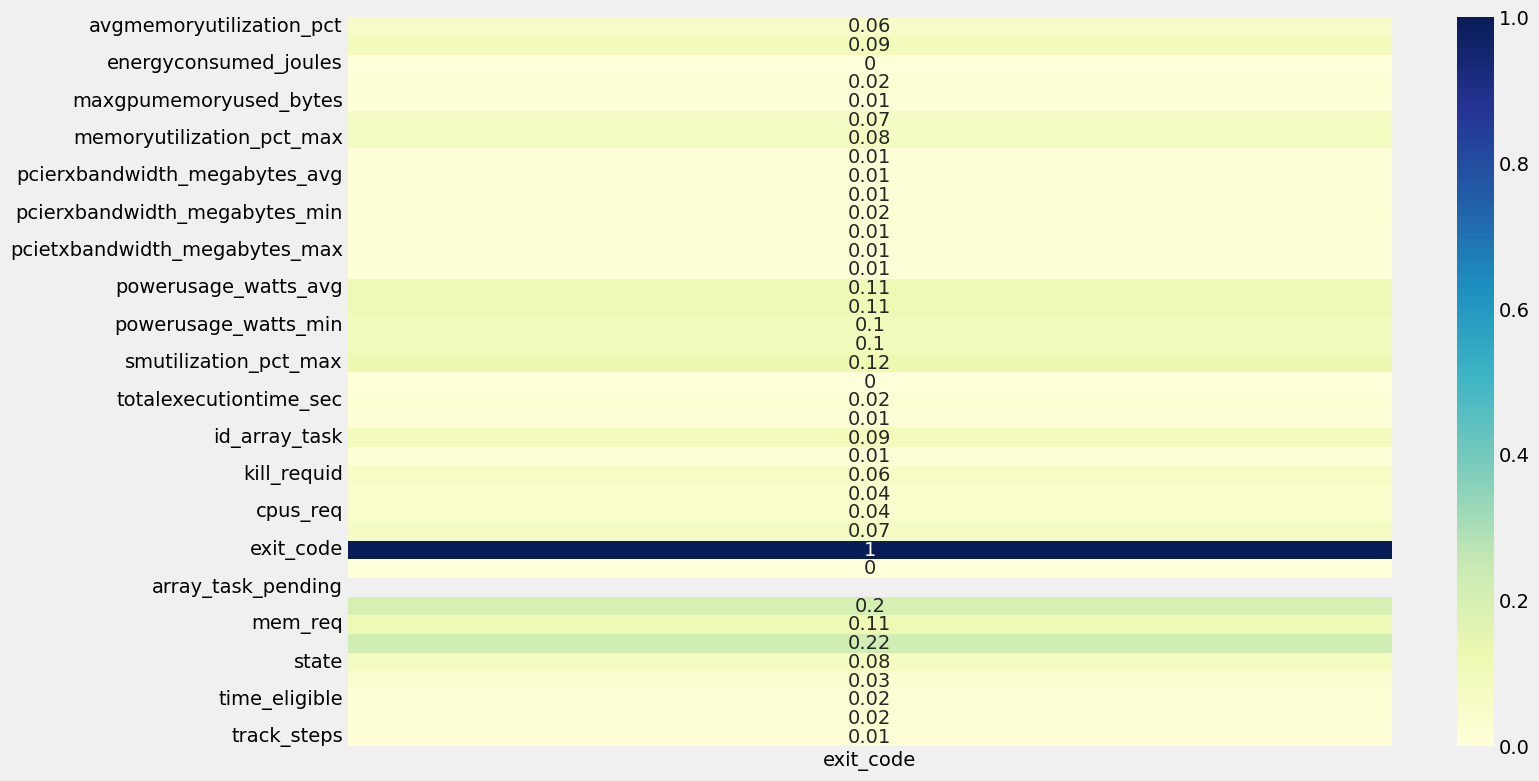

In [44]:
sns.heatmap(np.abs(merged_df.corr()[['exit_code']]).round(2), annot=True,  cmap="YlGnBu");

### Drop highly correlated Columns with least correlation to target, Drop Columns with all NaN

In [45]:
## Note down the columns that have high correlations to each other, but low correlation to target
# as they will yield the same results: 
# These columns should be dropped 
col_to_drop = ['avgmemoryutilization_pct', 'powerusage_watts_min', 'powerusage_watts_max', 
               'pcietxbandwidth_megabytes_max', 'pcietxbandwidth_megabytes_min', 'avgsmutilization_pct',
               'time_eligible', 'pcierxbandwidth_megabytes_max', 'pcierxbandwidth_megabytes_min',
               'smutilization_pct_max','smutilization_pct_min','smutilization_pct_avg',
               'memoryutilization_pct_max','memoryutilization_pct_min']

#drop columns that has all NaNs
col_to_drop.append('array_task_pending')


### Drop the columns that are not available for new jobs

In [46]:
# Since job is running the first time in production system, some of the data will not be available for them 
col_to_drop2 = ['energyconsumed_joules','maxgpumemoryused_bytes', 'memoryutilization_pct_avg',
                'pcierxbandwidth_megabytes_avg', 'powerusage_watts_min', 'time_start', 'time_end',
               'state','powerusage_watts_avg']
col_to_drop = col_to_drop + col_to_drop2

print(col_to_drop)

['avgmemoryutilization_pct', 'powerusage_watts_min', 'powerusage_watts_max', 'pcietxbandwidth_megabytes_max', 'pcietxbandwidth_megabytes_min', 'avgsmutilization_pct', 'time_eligible', 'pcierxbandwidth_megabytes_max', 'pcierxbandwidth_megabytes_min', 'smutilization_pct_max', 'smutilization_pct_min', 'smutilization_pct_avg', 'memoryutilization_pct_max', 'memoryutilization_pct_min', 'array_task_pending', 'energyconsumed_joules', 'maxgpumemoryused_bytes', 'memoryutilization_pct_avg', 'pcierxbandwidth_megabytes_avg', 'powerusage_watts_min', 'time_start', 'time_end', 'state', 'powerusage_watts_avg']


In [47]:
merged_df.drop(columns=col_to_drop, inplace=True, axis=1, errors='ignore')
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96805 entries, 0 to 96804
Data columns (total 22 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   gpu_id                         96805 non-null  int64  
 1   pcietxbandwidth_megabytes_avg  96805 non-null  float64
 2   totalexecutiontime_sec         96805 non-null  float64
 3   id_job                         96805 non-null  int64  
 4   id_array_task                  96805 non-null  int64  
 5   id_user                        96805 non-null  int64  
 6   kill_requid                    96805 non-null  int64  
 7   nodes_alloc                    96805 non-null  int64  
 8   cpus_req                       96805 non-null  int64  
 9   derived_ec                     96805 non-null  int64  
 10  exit_code                      96805 non-null  int64  
 11  gres_req                       96805 non-null  object 
 12  gres_alloc                     96805 non-null 

## Univariate Analysis

In [48]:
merged_df.head()

,gpu_id,pcietxbandwidth_megabytes_avg,totalexecutiontime_sec,id_job,id_array_task,id_user,kill_requid,nodes_alloc,cpus_req,derived_ec,...,gres_alloc,array_max_tasks,constraints,flags,mem_req,partition,priority,timelimit,track_steps,job_type
0,0,971.0,4452.47,4393785332,41161693674,8153593386,8153593386,1,20,0,...,gpu:1,0,xeon-g6,4,9223372036854784308,normal,10509,4294967295,0,LLSUB:BATCH
1,1,0.0,0.54,18177101425,41161693674,8153593386,51671871839,1,10,0,...,gpu:1,0,xeon-g6,4,9223372036854784308,normal,10912,4294967295,0,OTHER
2,0,1785.0,8398.30,39529488078,4595979483,8153593386,51671871839,1,1,0,...,gpu:1,0,xeon-g6,2,9223372036854784308,normal,110935,4294967295,0,LLSUB:INTERACTIVE
3,0,314.0,1851.72,19994333952,9124162775,8153593386,8153593386,1,20,0,...,gpu:1,0,xeon-g6,4,9223372036854784308,normal,10520,4294967295,0,LLSUB:BATCH
4,1,1109.0,0.99,397881706,10003786564,8153593386,51671871839,1,10,0,...,gpu:1,0,xeon-g6,4,9223372036854784308,normal,10912,4294967295,0,OTHER


In [49]:
merged_df.gres_alloc.value_counts()

gpu:1     65010
gpu:2     16922
gpu:8      5182
gpu:16     4624
gpu:32     2344
gpu:64     1344
gpu:4      1060
gpu:6       102
gpu:10       60
gpu:5        55
gpu:3        54
gpu:12       48
Name: gres_alloc, dtype: int64

In [50]:
merged_df.gres_req.unique()

array(['gpu:volta:1', 'gpu:volta:3', 'gpu:volta:2', 'gpu:1', 'gpu:2',
       'gpu:3', 'gpu:volta:4', 'gpu:volta:8', 'gpu:16', 'gpu:volta:16',
       'gpu:32', 'gpu:4', 'gpu:12', 'gpu:8', 'gpu:volta:10',
       'gpu:volta:6', 'gpu:volta:32', 'gpu:volta:5', 'gpu:volta:64',
       'gpu:volta:12', 'gpu:64'], dtype=object)

### convert gres_alloc and gres_req to int

In [51]:
merged_df['gres_alloc'] = merged_df['gres_alloc'].replace({'gpu:': ''},regex=True)

#gres_req
merged_df['gres_req'] = merged_df['gres_req'].replace({'gpu:': '', 'volta:': ''},regex=True)
print(merged_df.gres_req.unique())
print(merged_df.gres_alloc.unique())

['1' '3' '2' '4' '8' '16' '32' '12' '10' '6' '5' '64']
['1' '3' '2' '4' '8' '16' '32' '12' '10' '6' '5' '64']


In [52]:
merged_df.constraints.value_counts()

xeon-g6         96179
xeon-g6&6248      618
xeon-e5             8
Name: constraints, dtype: int64

### Drop highly skewed column 'constraint'

In [53]:
merged_df.drop(['constraints'], inplace=True, axis=1)

In [54]:
merged_df.describe()

,gpu_id,pcietxbandwidth_megabytes_avg,totalexecutiontime_sec,id_job,id_array_task,id_user,kill_requid,nodes_alloc,cpus_req,derived_ec,exit_code,array_max_tasks,flags,mem_req,priority,timelimit,track_steps
count,96805.000000,96805.000000,9.680500e+04,9.680500e+04,9.680500e+04,9.680500e+04,9.680500e+04,96805.000000,96805.000000,96805.000000,96805.000000,96805.000000,96805.000000,9.680500e+04,96805.000000,9.680500e+04,96805.000000
mean,0.454119,874.348887,2.185590e+04,3.343905e+10,1.675929e+10,3.568801e+10,4.804187e+10,2.342823,39.529869,21.180259,1404.003533,0.004401,4.142307,6.465459e+18,29469.308693,1.806124e+09,0.001023
std,0.497893,650.736056,9.938045e+04,1.943884e+10,1.945687e+10,1.922193e+10,1.182644e+10,4.489477,100.004327,637.236087,6656.117517,0.180678,1.224988,4.222719e+18,39383.967860,2.120166e+09,0.031963
min,0.000000,0.000000,8.000000e-02,1.055011e+06,2.513347e+06,2.689431e+08,2.689431e+08,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,8.192000e+03,0.000000,1.000000e+00,0.000000
25%,0.000000,247.000000,1.562000e+01,1.645700e+10,4.595979e+09,1.799426e+10,5.167187e+10,1.000000,1.000000,0.000000,0.000000,0.000000,4.000000,3.072000e+05,10127.000000,1.440000e+03,0.000000
50%,0.000000,837.000000,2.006200e+02,3.381195e+10,4.595979e+09,3.899757e+10,5.167187e+10,1.000000,10.000000,0.000000,0.000000,0.000000,4.000000,9.223372e+18,10233.000000,3.024000e+04,0.000000
75%,1.000000,1410.000000,5.553700e+03,5.007428e+10,2.735197e+10,5.091808e+10,5.167187e+10,1.000000,20.000000,0.000000,0.000000,0.000000,4.000000,9.223372e+18,10660.000000,4.294967e+09,0.000000
max,1.000000,2147.000000,2.895390e+06,6.710872e+10,6.710714e+10,6.701965e+10,6.608841e+10,32.000000,640.000000,56832.000000,65280.000000,8.000000,12.000000,9.223372e+18,119999.000000,4.294967e+09,1.000000


### Since Exit Code a target column, replace all of the code > 0 to 1, where 0 : Success and 1: Failure

In [55]:
merged_df['exit_code'] = np.where(merged_df['exit_code'] > 0, 1, merged_df['exit_code'])
merged_df.exit_code.unique()

array([0, 1])

### Simplify job_type column

In [56]:
merged_df['job_type'] = merged_df['job_type'].replace({'LLSUB:': '', 'LLMAPREDUCE:': ''}, regex=True)
merged_df.job_type.unique()

array(['BATCH', 'OTHER', 'INTERACTIVE', 'MAP'], dtype=object)

## Final Exploration of merged table: confirm the columns and if any further cleanup is required

In [57]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96805 entries, 0 to 96804
Data columns (total 21 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   gpu_id                         96805 non-null  int64  
 1   pcietxbandwidth_megabytes_avg  96805 non-null  float64
 2   totalexecutiontime_sec         96805 non-null  float64
 3   id_job                         96805 non-null  int64  
 4   id_array_task                  96805 non-null  int64  
 5   id_user                        96805 non-null  int64  
 6   kill_requid                    96805 non-null  int64  
 7   nodes_alloc                    96805 non-null  int64  
 8   cpus_req                       96805 non-null  int64  
 9   derived_ec                     96805 non-null  int64  
 10  exit_code                      96805 non-null  int64  
 11  gres_req                       96805 non-null  object 
 12  gres_alloc                     96805 non-null 

In [58]:
merged_df.gres_alloc.unique()

array(['1', '3', '2', '4', '8', '16', '32', '12', '10', '6', '5', '64'],
      dtype=object)

In [59]:
merged_df.partition.unique()

array(['normal', 'gaia', 'test'], dtype=object)

### Handle NaNs and Duplicates

In [60]:
merged_df.isna().mean()

gpu_id                           0.0
pcietxbandwidth_megabytes_avg    0.0
totalexecutiontime_sec           0.0
id_job                           0.0
id_array_task                    0.0
id_user                          0.0
kill_requid                      0.0
nodes_alloc                      0.0
cpus_req                         0.0
derived_ec                       0.0
exit_code                        0.0
gres_req                         0.0
gres_alloc                       0.0
array_max_tasks                  0.0
flags                            0.0
mem_req                          0.0
partition                        0.0
priority                         0.0
timelimit                        0.0
track_steps                      0.0
job_type                         0.0
dtype: float64

### Identify highly correlated features for target features and drop all others

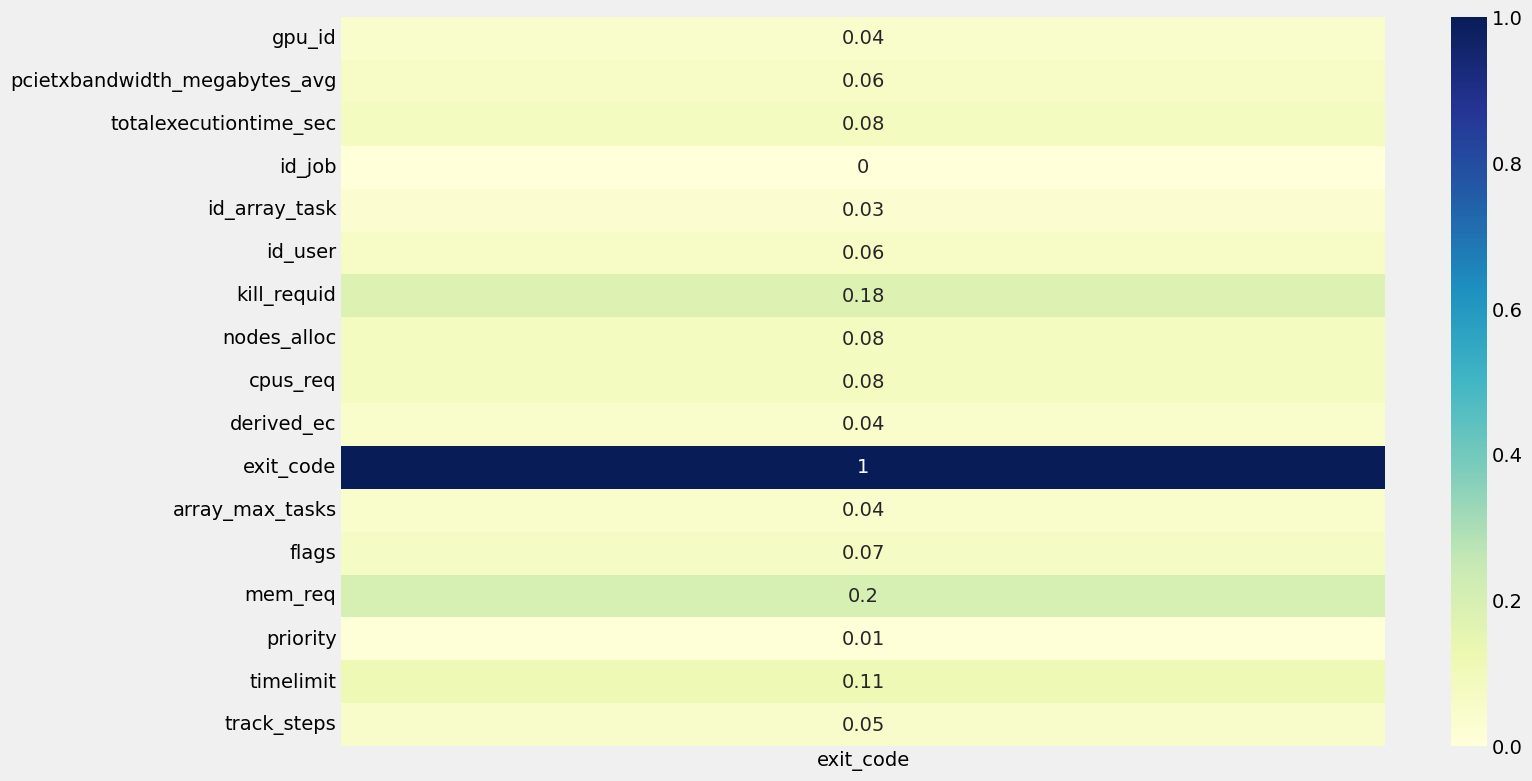

In [61]:
sns.heatmap(np.abs(merged_df.corr()[['exit_code']]).round(2), annot=True,  cmap="YlGnBu");

In [62]:
## Drop the features, that has very low correaltion <=.06

features_to_drop = ['gpu_id', 'priority','pcietxbandwidth_megabytes_avg',
                   'id_array_task', 'id_user', 'derived_ec', 'array_max_tasks', 'track_steps', 
                   'id_job']

## Notice that totalexecutiontime_sec is also low correlation, but not in dropped columns. 
# Its because total Execution time can be a logical factor in job failure and should be explored further
merged_df.drop(features_to_drop, axis=1, inplace=True, errors='ignore')
merged_df.shape

(96805, 12)

In [63]:
merged_df.duplicated().sum()

39761

### Drop Duplicates

In [64]:
merged_df.drop_duplicates(inplace=True)

# Data Preparation for modeling

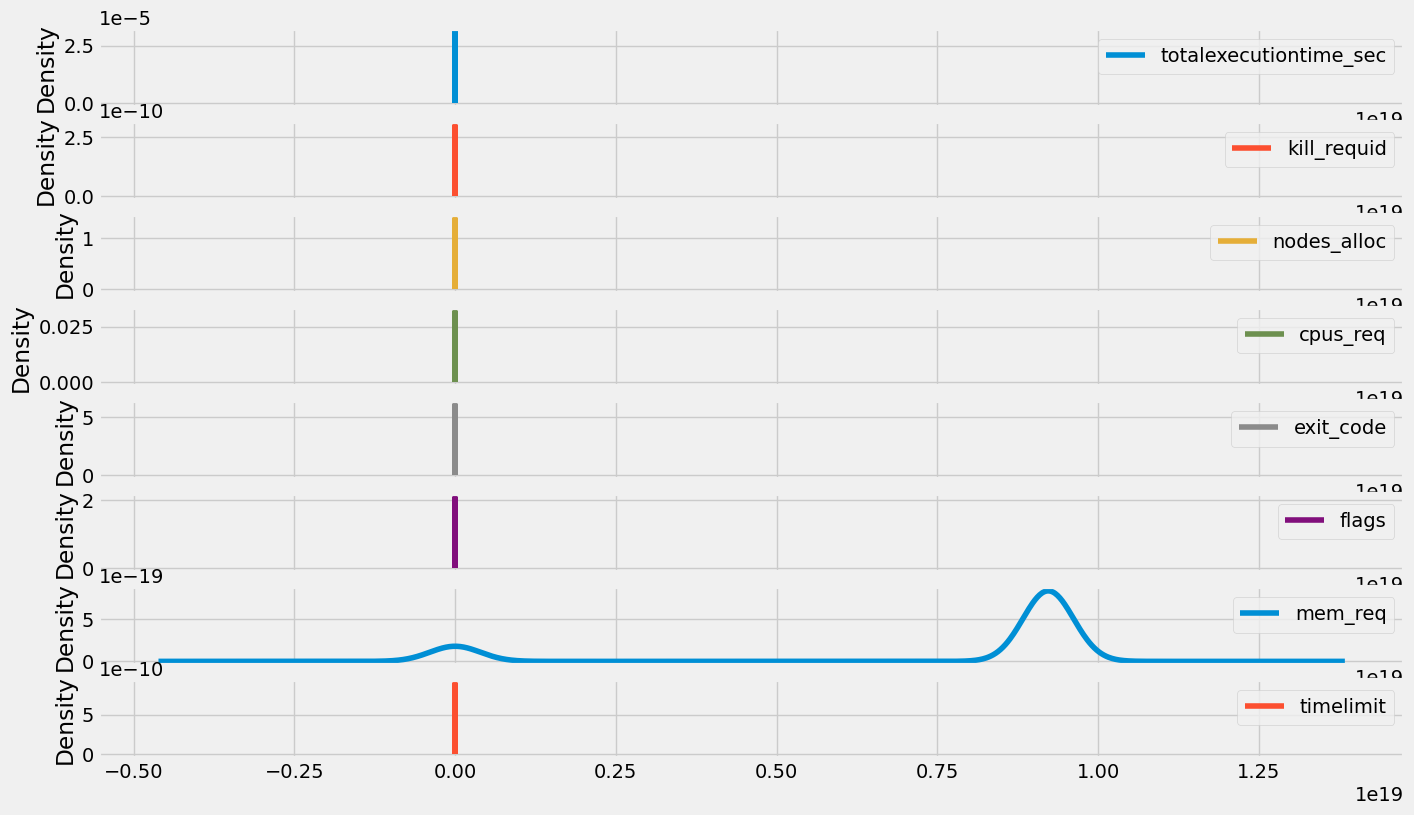

In [65]:
merged_df.plot(kind = 'kde', subplots = True);

## Prepare Categorical Data

In [66]:
merged_df_dummy = pd.get_dummies(merged_df, drop_first=True)
merged_df_dummy.head()

,totalexecutiontime_sec,kill_requid,nodes_alloc,cpus_req,exit_code,flags,mem_req,timelimit,gres_req_10,gres_req_12,...,gres_alloc_4,gres_alloc_5,gres_alloc_6,gres_alloc_64,gres_alloc_8,partition_normal,partition_test,job_type_INTERACTIVE,job_type_MAP,job_type_OTHER
0,4452.47,8153593386,1,20,0,4,9223372036854784308,4294967295,0,0,...,0,0,0,0,0,1,0,0,0,0
1,0.54,51671871839,1,10,0,4,9223372036854784308,4294967295,0,0,...,0,0,0,0,0,1,0,0,0,1
2,8398.30,51671871839,1,1,1,2,9223372036854784308,4294967295,0,0,...,0,0,0,0,0,1,0,1,0,0
3,1851.72,8153593386,1,20,0,4,9223372036854784308,4294967295,0,0,...,0,0,0,0,0,1,0,0,0,0
4,0.99,51671871839,1,10,1,4,9223372036854784308,4294967295,0,0,...,0,0,0,0,0,1,0,0,0,1


In [67]:
merged_df_dummy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57044 entries, 0 to 96804
Data columns (total 35 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   totalexecutiontime_sec  57044 non-null  float64
 1   kill_requid             57044 non-null  int64  
 2   nodes_alloc             57044 non-null  int64  
 3   cpus_req                57044 non-null  int64  
 4   exit_code               57044 non-null  int64  
 5   flags                   57044 non-null  int64  
 6   mem_req                 57044 non-null  uint64 
 7   timelimit               57044 non-null  int64  
 8   gres_req_10             57044 non-null  uint8  
 9   gres_req_12             57044 non-null  uint8  
 10  gres_req_16             57044 non-null  uint8  
 11  gres_req_2              57044 non-null  uint8  
 12  gres_req_3              57044 non-null  uint8  
 13  gres_req_32             57044 non-null  uint8  
 14  gres_req_4              57044 non-null

In [68]:
merged_df.exit_code.value_counts()

0    42276
1    14768
Name: exit_code, dtype: int64

# Test Train Split

In [69]:
#splitting the data
X = merged_df_dummy.drop(columns='exit_code').copy()
y = merged_df['exit_code']

# Test train split
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=2)

print(X_train.shape)
print(X_test.shape)

(42783, 34)
(14261, 34)


## Scale the data

array([<AxesSubplot:ylabel='Density'>, <AxesSubplot:ylabel='Density'>,
       <AxesSubplot:ylabel='Density'>, <AxesSubplot:ylabel='Density'>,
       <AxesSubplot:ylabel='Density'>, <AxesSubplot:ylabel='Density'>,
       <AxesSubplot:ylabel='Density'>, <AxesSubplot:ylabel='Density'>,
       <AxesSubplot:ylabel='Density'>, <AxesSubplot:ylabel='Density'>,
       <AxesSubplot:ylabel='Density'>, <AxesSubplot:ylabel='Density'>,
       <AxesSubplot:ylabel='Density'>, <AxesSubplot:ylabel='Density'>,
       <AxesSubplot:ylabel='Density'>, <AxesSubplot:ylabel='Density'>,
       <AxesSubplot:ylabel='Density'>, <AxesSubplot:ylabel='Density'>,
       <AxesSubplot:ylabel='Density'>, <AxesSubplot:ylabel='Density'>,
       <AxesSubplot:ylabel='Density'>, <AxesSubplot:ylabel='Density'>,
       <AxesSubplot:ylabel='Density'>, <AxesSubplot:ylabel='Density'>,
       <AxesSubplot:ylabel='Density'>, <AxesSubplot:ylabel='Density'>,
       <AxesSubplot:ylabel='Density'>, <AxesSubplot:ylabel='Density'>,
      

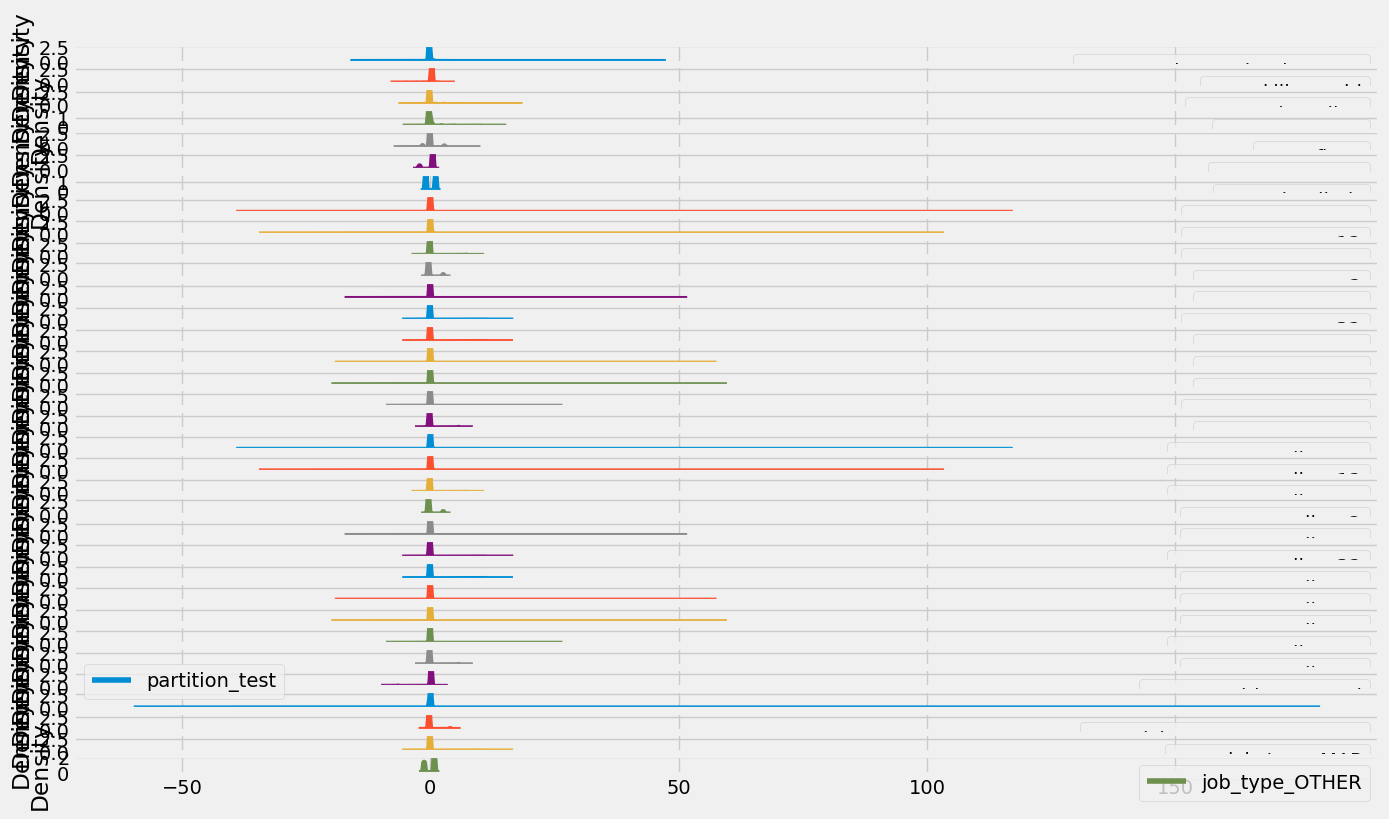

In [70]:
scaler = StandardScaler()
numCol = X_train.select_dtypes(np.number).columns.to_list()
train_scaled = X_train.copy()
train_scaled[numCol] = scaler.fit_transform(X_train[numCol])

test_scaled = X_test.copy()
test_scaled[numCol] = scaler.transform(X_test[numCol])

# Create kde Plot for scaled data
train_scaled.plot(kind = 'kde', subplots = True)


# Modeling

## Apply Various models and compare the performances

### Create Dataframe to capture performances of various models

In [71]:
res_dict = {'model': [],
           'train score': [],
           'test score': [],
           'average fit time': []}
df_results = pd.DataFrame(res_dict)
df_results.head()

,model,train score,test score,average fit time


### Apply models and manually compare the performances

In [72]:
models = [KNeighborsClassifier(), LogisticRegression(random_state=42), 
          DecisionTreeClassifier(random_state=42), SVC(random_state=42), RandomForestClassifier(random_state=42),
          XGBClassifier(random_state=42)
         ]

for m in models:
    print(m)
    t1 = time.time()
    model = m
    model.fit(X_train, y_train)
    fit_time = time.time() - t1
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    df_results.loc[len(df_results.index)] = [m, train_score,test_score,fit_time ]

df_results.set_index('model')
df_results


KNeighborsClassifier()
LogisticRegression(random_state=42)
DecisionTreeClassifier(random_state=42)
SVC(random_state=42)
RandomForestClassifier(random_state=42)
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)


,model,train score,test score,average fit time
0,KNeighborsClassifier(),0.760933,0.762920,0.008439
1,LogisticRegression(random_state=42),0.740762,0.742164,0.082148
2,DecisionTreeClassifier(random_state=42),0.995232,0.885211,0.134891
3,SVC(random_state=42),0.740762,0.742164,50.159787
4,"(DecisionTreeClassifier(max_features='auto', r...",0.995162,0.896150,2.663611
5,"XGBClassifier(base_score=None, booster=None, c...",0.920085,0.906388,1.459101


### CONCLUSION
**Best Model: XGBClassifier**
- DecisionTree although generates highest Train score, it seems to be overfitting
- The same is the case with RandomForextClassifier, which uses DecisionTree as well. Its high score, bt overfitting
- SVC model's average fit_time is very high, and the score is poor even though test score is very close to train score
- XGBClassifier is the best performing in terms of accuracy score without overfitting. The fitting time is higher than KNN and LogixticRegression, but it's in accepatble range

## Confusion Matrix Using Best Performing Model: XGBClassifier

### XGBClassifier Model Predictions 

In [73]:
# Create XGB Classifier, ensure to use importance_type = weight. xgb by default uses 'gain' for importance_type
xgb = XGBClassifier(random_state=42, importance_type='weight')
xgb.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=0)

# Print the classifier
xgb


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None,
              importance_type='weight', interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=42, ...)

### Confusion Matrix for Training Data

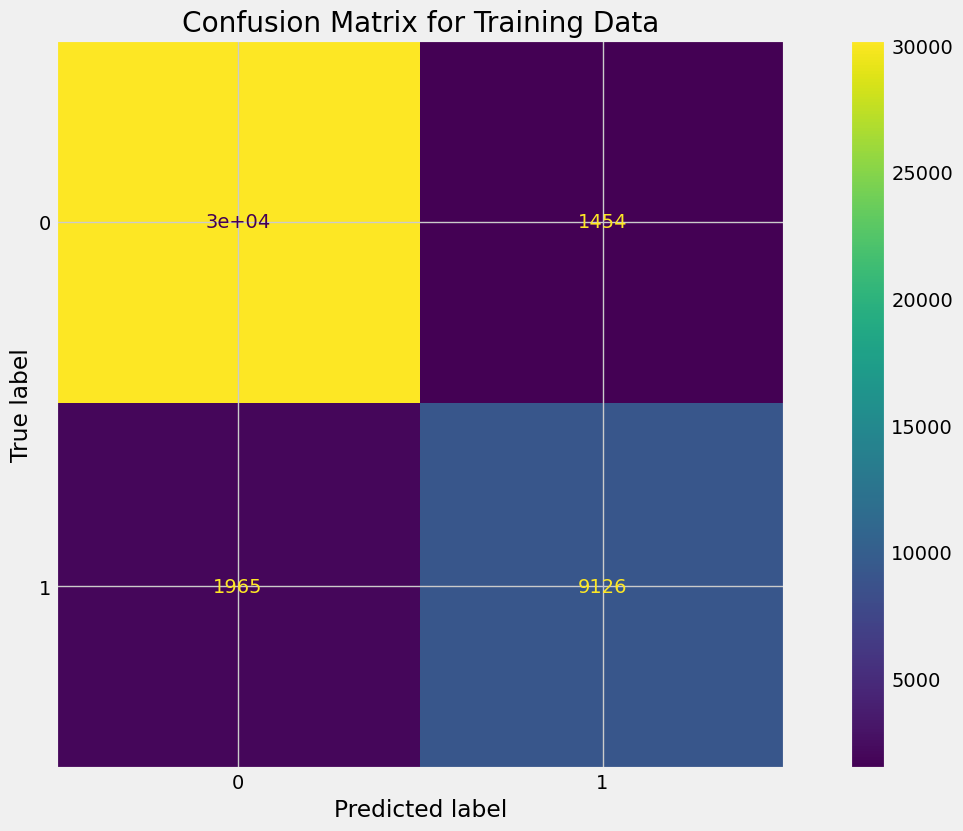

In [74]:
#create prediction on training set. This can be used for comparision against test predictions
train_pred = xgb.predict(X_train)

# confusion Matrix for training set
cm = confusion_matrix(y_train, train_pred, labels = xgb.classes_)

# Display Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix= cm,display_labels= xgb.classes_)

# show the plot
disp.plot()
plt.title('Confusion Matrix for Training Data')
plt.show()

### Confusion Matrix for Test Data

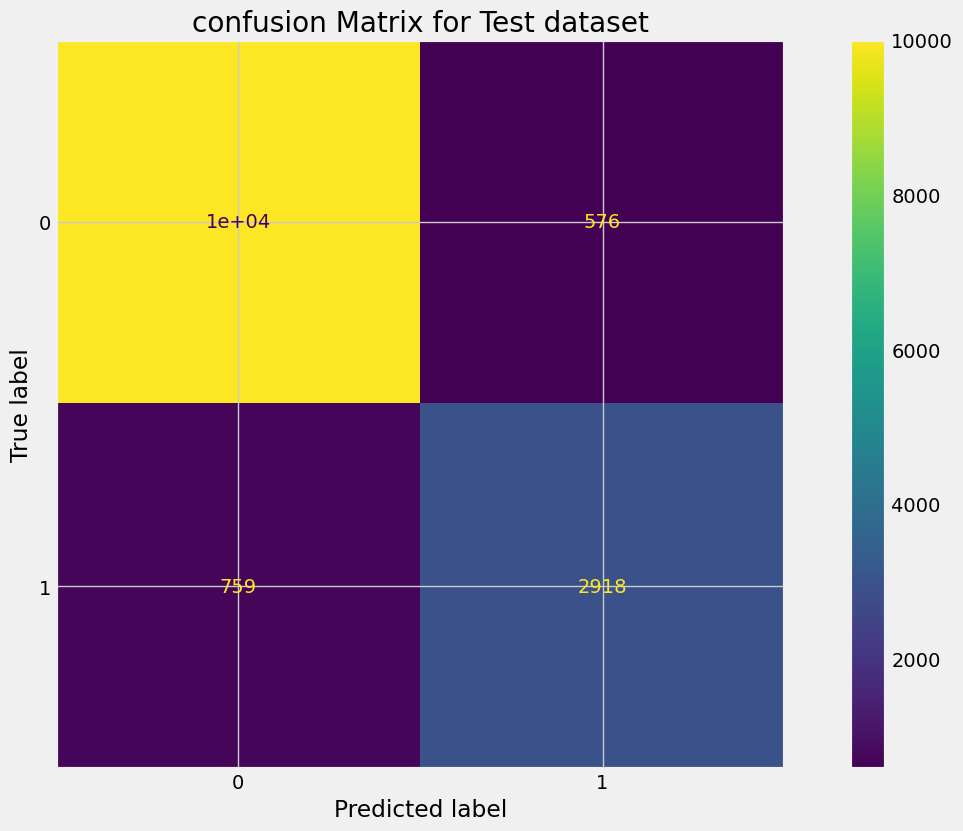

In [75]:
# Create predictions for test data
test_pred = xgb.predict(X_test)

# confusion Matrix for test data
cm = confusion_matrix(y_test, test_pred, labels = xgb.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix= cm,display_labels= xgb.classes_)

# show the plot
disp.plot()
plt.title("confusion Matrix for Test dataset")
plt.show()



### CONCLUSION
both test and train data confusion matrix shows a higher number of false positives. As a reminder, 0: success, and 1:Failure for our data set. It's better to flag some jobs as possible failures in production, as a failing job affect the production system's availability. 
On the other hand, we also don't want to increase false failures to a significantly higher number, as that will affect the production release deadlines and hence question the ability of the model to detect issues.
As conclusion, we will leave the model to above settings and will not further tune it to adjust the false positives

## Get features by importance

### Use feature_importance_ to get the percentage weight

[5.1966667e-01 3.2000002e-02 1.4000000e-02 1.2033334e-01 2.8666666e-02
 4.0333334e-02 1.3666667e-01 0.0000000e+00 0.0000000e+00 5.3333333e-03
 3.3333335e-02 2.3333333e-03 0.0000000e+00 5.6666667e-03 3.3333333e-04
 3.3333333e-04 0.0000000e+00 2.0000001e-03 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 5.3333333e-03
 0.0000000e+00 1.4666666e-02 5.6666667e-03 3.3333335e-02]


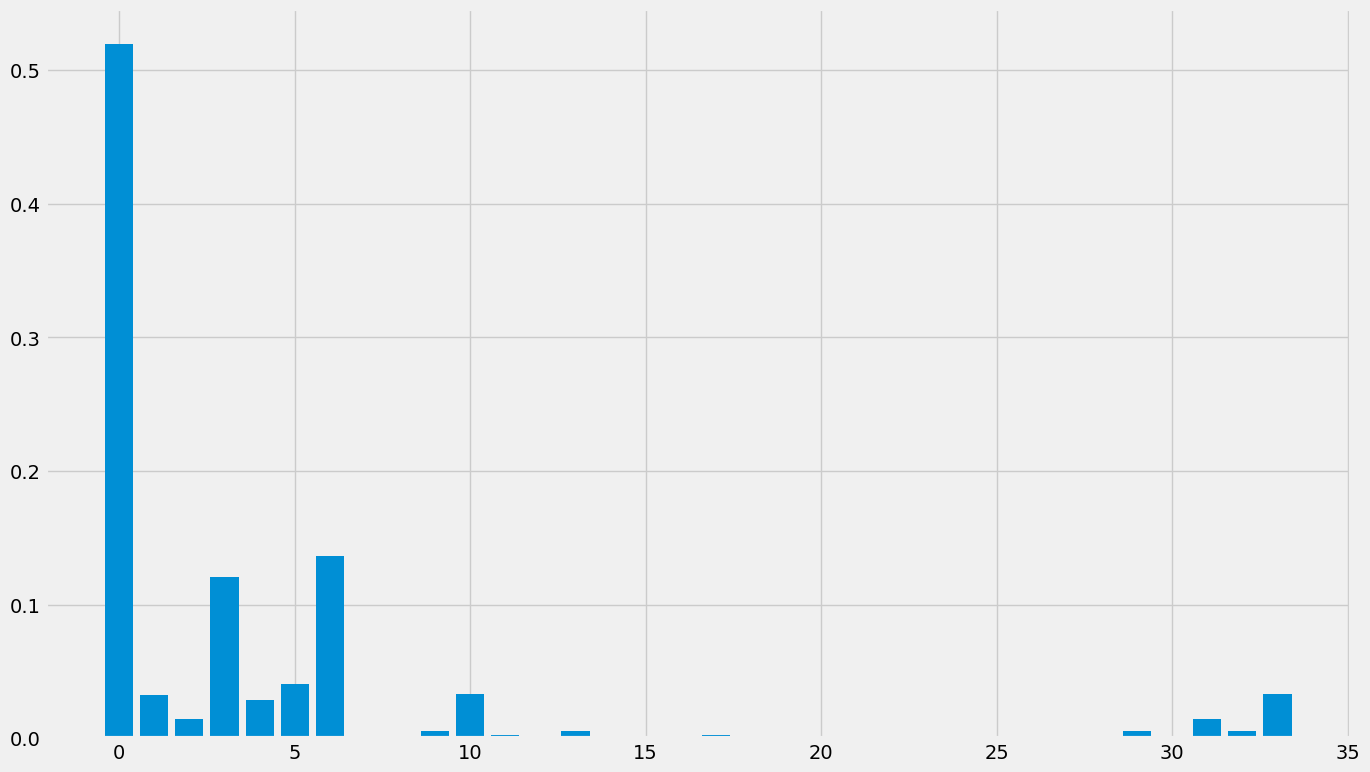

In [76]:
print(xgb.feature_importances_) # it should use weight as mentioned during the model definition
plt.bar(range(len(xgb.feature_importances_)), xgb.feature_importances_)
plt.show()

### use plot_importance function provided by xgb to get the raw importance. 

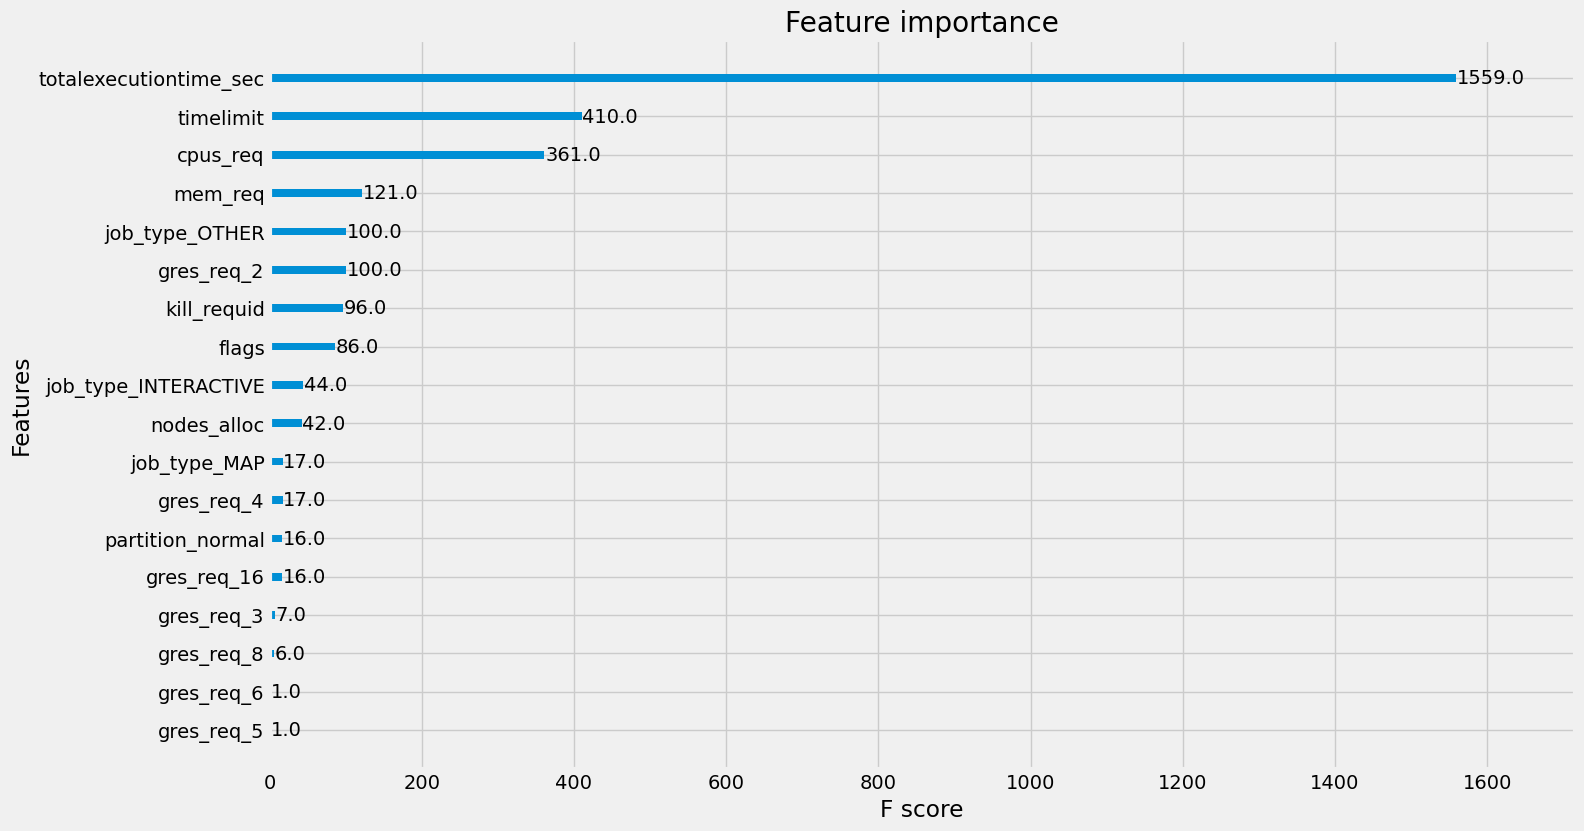

In [77]:
# Plot Importance graph should match the feature_importance_ graph created above and both use importance_type='weight'
plot_importance(xgb, importance_type='weight')
plt.show()

# Conclusion

KGBClassifier gives the best performance and hence was used as final model to understand the important features.

- DecisionTree although generates highest Train score, it seems to be overfitting with train score > .99 and test score <.9
- The same is the case with RandomForextClassifier, which uses DecisionTree as well. Its high score, bt overfitting
- SVC model's average fit_time is very high (~50s), and the score is poor even though test score is very close to train score
- XGBClassifier is the best performing in terms of accuracy score without overfitting. The fitting time is higher than KNN and LogixticRegression, but it's in accepatble range(~1.14). 

The model provide very low number of false positives and false-negatives compared to the correct predictions. For this problem statement, having slightly higher false positives are preferable as that prevent the production systems from unlikely circumstances. The program doesn't try to reduce the false-negatives though, because that may raise questions on the model's reliability and will cause unnecessary delays in the production releases.

As per the model, best feature analysis, total execution time is the feature with highest importance, with time line, CPU_req and Memory_req following. This makes sense that if a job is running for prolonged period, it blocks the system resources for that long time, and hence may end up in failing state. 
